In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode,substring, length
from pyspark.sql.types import DecimalType, StringType
from pyspark.sql.types import DoubleType
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setting up spark
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


print(spark)
print(spark.version)

3.0.0-preview2


In [4]:
topinves_df=spark.read.csv("hdfs://localhost:9000/eda/dc_investments.csv", header='true', inferSchema='true')

In [5]:
columns_to_drop = ['_c0', 'company_permalink','investor_permalink','funding_round_permalink']
topinves_df = topinves_df.drop(*columns_to_drop)

In [6]:
topinves_df.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- company_category_list: string (nullable = true)
 |-- company_country_code: string (nullable = true)
 |-- company_region: string (nullable = true)
 |-- company_city: string (nullable = true)
 |-- investor_name: string (nullable = true)
 |-- investor_country_code: string (nullable = true)
 |-- funding_round_type: string (nullable = true)
 |-- funded_at: string (nullable = true)
 |-- raised_amount_usd: double (nullable = true)



In [8]:
topinves_df.describe('funded_at').show()

+-------+----------+
|summary| funded_at|
+-------+----------+
|  count|    134686|
|   mean|      null|
| stddev|      null|
|    min|1979-01-01|
|    max|2015-12-04|
+-------+----------+



# Who are the top 20 investors in the last decade - (2005 to 2015) ?


In [9]:
topinves_df.createOrReplaceTempView("investments")

In [10]:
import pyspark.sql.functions as func
invest_count=topinves_df.groupBy('investor_name').count().select(func.col("investor_name").alias("distinct_investor"),func.col("count").alias("Investor_count")).sort(col("Investor_count").desc())
invest_count.show()
type(invest_count)

+--------------------+--------------+
|   distinct_investor|Investor_count|
+--------------------+--------------+
|     Sequoia Capital|          1025|
|               Wayra|           926|
|        500 Startups|           924|
|New Enterprise As...|           891|
|       Intel Capital|           844|
|        Y Combinator|           807|
|               Accel|           774|
|      Start-Up Chile|           727|
|Kleiner Perkins C...|           726|
|            SV Angel|           625|
|Draper Fisher Jur...|           608|
|           Techstars|           536|
|         First Round|           497|
|Bessemer Venture ...|           459|
|      Index Ventures|           457|
|           Benchmark|           420|
|   Greylock Partners|           418|
|Lightspeed Ventur...|           415|
| Andreessen Horowitz|           415|
|             Venrock|           404|
+--------------------+--------------+
only showing top 20 rows



pyspark.sql.dataframe.DataFrame

In [11]:
trimed_df = topinves_df.select('investor_name','raised_amount_usd',  substring('funded_at',-0,4).cast('int').alias('year'))

In [12]:
trimed_df.show()
trimed_df.count()

+--------------------+-----------------+----+
|       investor_name|raised_amount_usd|year|
+--------------------+-----------------+----+
| DT Capital Partners|        2000000.0|2008|
|VCDE Venture Part...|        6000000.0|2014|
| Cyberport Hong Kong|          41250.0|2014|
|         Capital One|            2.0E7|2015|
|Nexus Venture Par...|        3000000.0|2013|
|Nexus Venture Par...|            2.0E7|2015|
|Nexus Venture Par...|        1700000.0|2013|
|Nexus Venture Par...|        8900000.0|2014|
|        Transamerica|            2.0E7|2015|
|Transamerica Vent...|        8900000.0|2014|
|Anand Babu Periasamy|        1700000.0|2013|
|        Ash Bhardwaj|        8900000.0|2014|
|       Rajesh Ambati|        8900000.0|2014|
|   Camp One Ventures|         150000.0|2014|
|   Camp One Ventures|        6000000.0|2013|
|                 CRV|        1000050.0|2011|
|General Catalyst ...|        1000050.0|2011|
|       Kima Ventures|         150000.0|2014|
|            SV Angel|        1000

134686

In [13]:
from2006 = trimed_df.filter(col('year') > 2005).sort(col('year').desc())

In [14]:
from2006.count()

120229

In [15]:
from2006.describe('year').show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|            120229|
|   mean|2011.7121909023613|
| stddev| 2.715689673824666|
|    min|              2006|
|    max|              2015|
+-------+------------------+



In [16]:
from2006.createOrReplaceTempView("invest")

In [17]:
s1 =  """
            SELECT investor_name,  
            SUM(raised_amount_usd) AS TOTAL, 
            CAST(SUM(raised_amount_usd) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM invest GROUP 
            BY investor_name
            """

In [18]:
s1DF = spark.sql(s1)
s1DF.show()

+--------------------+-------------------+---------+
|       investor_name|              TOTAL|TOTAL_DEC|
+--------------------+-------------------+---------+
|       1776 Ventures|           2.3355E7| 23355000|
|    BDS Venture Fund|       1.13670576E8|113670576|
|         Bertelsmann|          7.38032E8|738032000|
|  New Dream Networks|             1.94E7| 19400000|
|Vandewater Capita...|              1.6E7| 16000000|
|  The New York Times|          2.13475E8|213475000|
|       Talis Capital|        6.8710533E7| 68710533|
|Matrix Partners I...|            4.051E8|405100000|
|            Aplazame|           198512.0|   198512|
|Nordic Venture Pa...|1.587768518590998E8|158776852|
|          Semil Shah|       1.64461774E8|164461774|
|       GREE Ventures|        1.3077675E8|130776750|
|      Michael Pierce|              2.2E7| 22000000|
|      Scrum Ventures|          1.19132E8|119132000|
|   WestTech Ventures|       1.21832808E8|121832808|
|    The Phoenix Fund|          6000000.0|  60

In [19]:
s2 =  """
            SELECT investor_name, SUM(raised_amount_usd) AS TOTAL, 
            CAST(SUM(raised_amount_usd) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM invest GROUP 
            BY investor_name
            ORDER BY TOTAL DESC
            """

In [20]:
s2DF = spark.sql(s2)
s2DF.show(20)

+--------------------+--------------------+-----------+
|       investor_name|               TOTAL|  TOTAL_DEC|
+--------------------+--------------------+-----------+
|     Sequoia Capital|     2.3001961971E10|23001961971|
|Kleiner Perkins C...|     2.2454759845E10|22454759845|
|The Blackstone Group|         1.886836E10|18868360000|
|New Enterprise As...|     1.8695414504E10|18695414504|
|       Goldman Sachs|1.626626136237652...|16266261362|
|             Alibaba|         1.621865E10|16218650000|
|               Accel|     1.6217341822E10|16217341822|
|Tiger Global Mana...|      1.432471644E10|14324716440|
|    Temasek Holdings|     1.2921778365E10|12921778365|
| Andreessen Horowitz|1.224193867957980...|12241938680|
|       Intel Capital|1.176824848975076...|11768248490|
|          DST Global|        1.1556307E10|11556307000|
|       T. Rowe Price|        9.69493433E9| 9694934330|
|      Index Ventures| 8.767821990252655E9| 8767821990|
|Wellington Manage...|       8.610779997E9| 8610

In [21]:
s2_pdf = s2DF.toPandas()
x2_pdf = invest_count.toPandas()

In [22]:
cnt1=s2_pdf[['investor_name','TOTAL']].copy()
xnt1=x2_pdf[['distinct_investor', 'Investor_count']].copy()
pl0t1=xnt1.head(20)
pl0t2=cnt1.head(20)
pl0t2

,investor_name,TOTAL
0,Sequoia Capital,2.300196e+10
1,Kleiner Perkins Caufield & Byers,2.245476e+10
2,The Blackstone Group,1.886836e+10
3,New Enterprise Associates,1.869541e+10
4,Goldman Sachs,1.626626e+10
5,Alibaba,1.621865e+10
6,Accel,1.621734e+10
7,Tiger Global Management,1.432472e+10
8,Temasek Holdings,1.292178e+10
9,Andreessen Horowitz,1.224194e+10


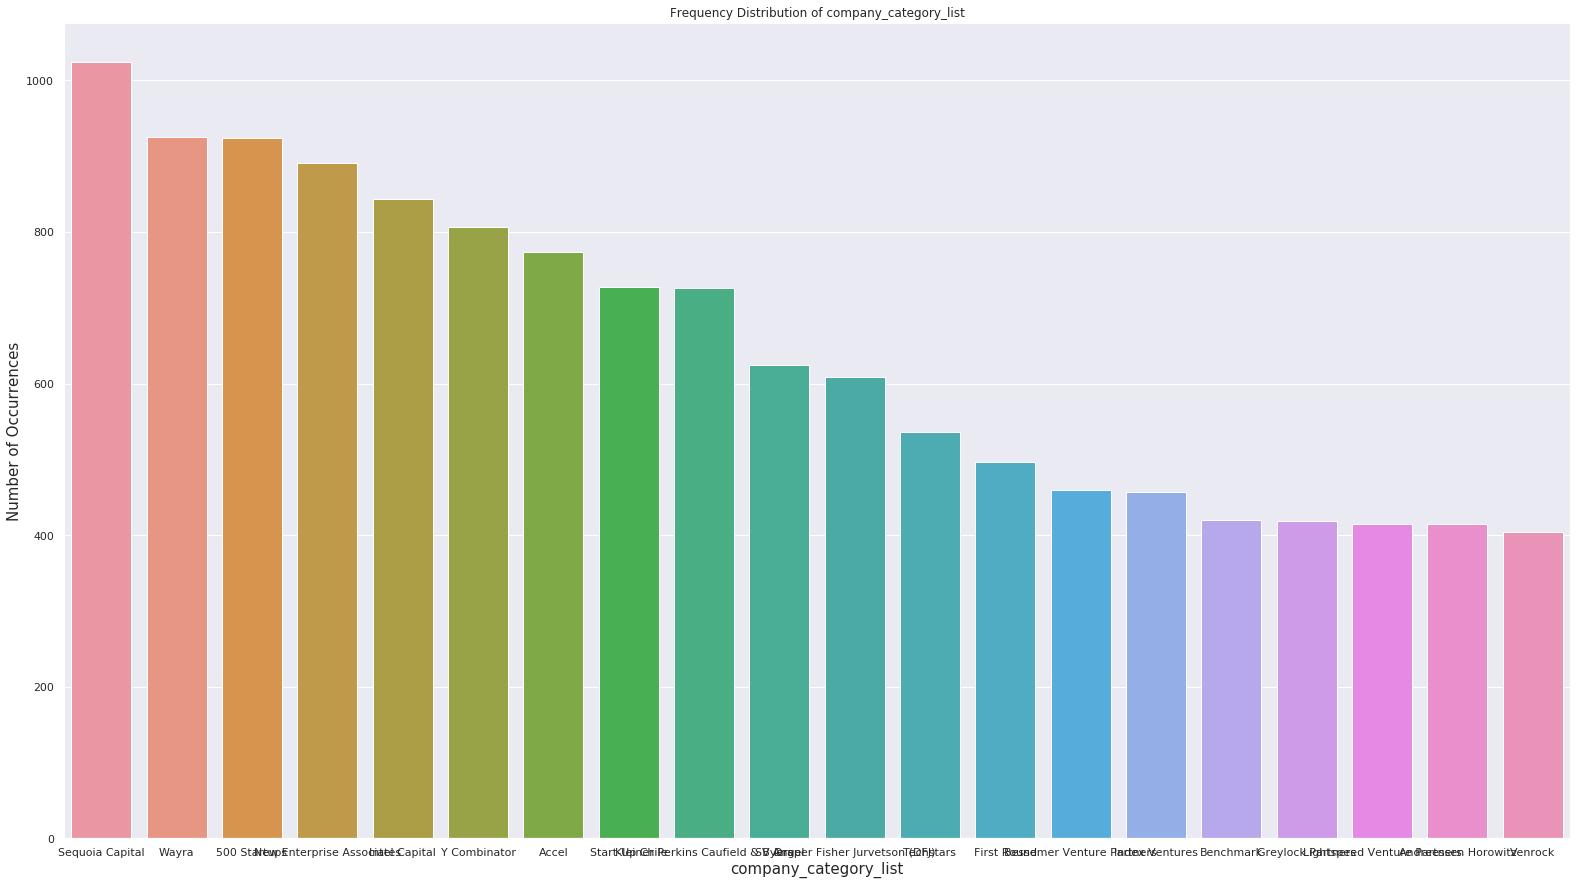

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(27,15)})
sns.set(style="darkgrid")
sns.barplot(pl0t1.distinct_investor, pl0t1.Investor_count, alpha=1)
plt.title('Frequency Distribution of company_category_list')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('company_category_list', fontsize=15)
plt.show()

In [25]:
y = pl0t1['Investor_count']
x =pl0t1['distinct_investor']
#text= 'Company Category: '+ x
ytitle ='Funding (USD $)'
title = 'Top 10 Industries by Startup Funding'


data = [go.Bar(
        x=x,
        y=y,
        #text= text,
        marker=dict(
        opacity=0.8,
    ),
    )]     

layout = go.Layout(
    showlegend=False,
    xaxis=dict(
        tickfont=dict(
            size=9,
            color='rgb(107, 107, 107)',
            ),
          titlefont=dict(
        size=12,
        color='rgb(107, 107, 107)',
        ),
    ),
    yaxis=dict(
        title=ytitle,
        titlefont=dict(
            size=11,
            color='rgb(107, 107, 107)',
        ),
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        ),
    ),
    title=title,
        titlefont=dict(
        size=16,
        color='rgb(107, 107, 107)'
    ),
    margin={"t": 100, "b": 100, "l": 100, "r": 100},
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [24]:
import pandas as pd
import numpy as np
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
from datetime import datetime

In [23]:
!pip install chart-studio

     |████████████████████████████████| 81kB 2.5MB/s eta 0:00:01


In [26]:
!pip install cufflinks

     |████████████████████████████████| 81kB 2.5MB/s eta 0:00:01


  Created wheel for cufflinks: filename=cufflinks-0.17.0-cp37-none-any.whl size=67744 sha256=fb702ea4ab6c2577aed90e523d373f51f0ec85556201ecc4ec083f3a3dc3564c
  Stored in directory: /home/shyam/.cache/pip/wheels/44/d7/dc/e830ab00bc2dd3b2731295103baa070f8cbdda8891f71a7a8d
Successfully built cufflinks


In [26]:
s2DF.show(20)

+--------------------+--------------------+-----------+
|       investor_name|               TOTAL|  TOTAL_DEC|
+--------------------+--------------------+-----------+
|     Sequoia Capital|     2.3001961971E10|23001961971|
|Kleiner Perkins C...|     2.2454759845E10|22454759845|
|The Blackstone Group|         1.886836E10|18868360000|
|New Enterprise As...|     1.8695414504E10|18695414504|
|       Goldman Sachs|1.626626136237652...|16266261362|
|             Alibaba|         1.621865E10|16218650000|
|               Accel|     1.6217341822E10|16217341822|
|Tiger Global Mana...|      1.432471644E10|14324716440|
|    Temasek Holdings|     1.2921778365E10|12921778365|
| Andreessen Horowitz|1.224193867957980...|12241938680|
|       Intel Capital|1.176824848975076...|11768248490|
|          DST Global|        1.1556307E10|11556307000|
|       T. Rowe Price|        9.69493433E9| 9694934330|
|      Index Ventures| 8.767821990252655E9| 8767821990|
|Wellington Manage...|       8.610779997E9| 8610

In [27]:
x = pl0t2['TOTAL']
y =pl0t2['investor_name']
text= 'Company: '+ y
xtitle ='Amount Invested (USD $)'
title = 'Top 10 Investers by Amount invested'
ticktext = ('as','d','s')

data = [go.Bar(
        x=x,
        y=y,
        orientation = 'h',
        text= text,
        marker=dict(
        opacity=0.8,
    ),
    )]     

layout = go.Layout(
    showlegend=False,
    xaxis=dict(
        title=xtitle,
        tickfont=dict(
            size=9,
            color='rgb(107, 107, 107)',
            ),
        titlefont=dict(
        size=12,
        color='rgb(107, 107, 107)',
        ),
    ),
    yaxis=dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        ticktext = ['Sequoia Capital', 'Kleiner Perkins', 'The Blackstone','New Enterprise', 'Goldman Sachs',
                    'Alibaba','Accel','Tiger Global','Temasek Holdings', 'Andreessen Horowitz',
                    'Intel Capital', 'DST Globa', 'T. Rowe Price', 'Index Ventures', 'Wellington', 'Khosla Ventures',
                    'Bessemer Venture', 'Lightspeed Venture', 'Fidelity Investments', 'Greylock Partners'],
        autorange="reversed",
        tickfont=dict(
            size=11,
            color='rgb(107, 107, 107)'
        ),
    ),
    title=title,
    titlefont=dict(
        size=16,
        color='rgb(107, 107, 107)'
    ),
    margin={"t": 100, "b": 100, "l": 100, "r": 100},
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Which were the business sectors in growth before the 21st century and after 2000 and its comparision?

In [28]:
topinves_df.select('raised_amount_usd', 'funded_at','company_category_list').filter(topinves_df.company_category_list.contains('|')).show(5, truncate = False)

+-----------------+----------+----------------------------+
|raised_amount_usd|funded_at |company_category_list       |
+-----------------+----------+----------------------------+
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|500000.0         |2009-05-15|Art|E-Commerce|Marketplaces |
|6602693.89911084 |2015-11-04|Local Businesses|Restaurants|
|1736910.0        |2013-11-13|Local Businesses|Restaurants|
+-----------------+----------+----------------------------+
only showing top 5 rows



In [29]:
splitCategory = topinves_df.select('raised_amount_usd',  substring('funded_at',-0,4).cast('int').alias('year')
                       , split(col("company_category_list")
                       , "[|]s*").alias("category_list")).filter(col('year') >= 1990)
splitCategory.show(5, truncate = False)

+-----------------+----+-------------+
|raised_amount_usd|year|category_list|
+-----------------+----+-------------+
|2000000.0        |2008|[Curated Web]|
|6000000.0        |2014|[Software]   |
|41250.0          |2014|[Games]      |
|2.0E7            |2015|[Analytics]  |
|3000000.0        |2013|[Analytics]  |
+-----------------+----+-------------+
only showing top 5 rows



In [30]:
open_list=splitCategory.select('raised_amount_usd','year', explode('category_list').alias('category'))

In [31]:
open_list.show(5)

+-----------------+----+-----------+
|raised_amount_usd|year|   category|
+-----------------+----+-----------+
|        2000000.0|2008|Curated Web|
|        6000000.0|2014|   Software|
|          41250.0|2014|      Games|
|            2.0E7|2015|  Analytics|
|        3000000.0|2013|  Analytics|
+-----------------+----+-----------+
only showing top 5 rows



In [32]:
open_list.createOrReplaceTempView("comparision")

In [40]:
sqlDF = spark.sql("SELECT * FROM comparision")

In [33]:
sql1=  """
            SELECT CATEGORY, 
            CAST(YEAR AS INT), 
            SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM comparision 
            GROUP BY CATEGORY, YEAR
            ORDER BY CATEGORY,YEAR
            """
#  ORDER BY YEAR DESC, TOTAL DESC

In [34]:
df1 = spark.sql(sql1)
df1.show(5)

+--------+----+------------+---------+
|CATEGORY|YEAR|       TOTAL|TOTAL_DEC|
+--------+----+------------+---------+
|      3D|2003|      3.64E8|364000000|
|      3D|2005|   1129590.0|  1129590|
|      3D|2006|   4.20152E7| 42015200|
|      3D|2007|  9.866656E7| 98666560|
|      3D|2008|1.53273358E8|153273358|
+--------+----+------------+---------+
only showing top 5 rows



In [53]:
sql2 =  """
            SELECT CATEGORY, SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM comparision GROUP 
            BY CATEGORY
            ORDER BY TOTAL DESC
            LIMIT 7
            """

In [55]:
df2 = spark.sql(sql2)
df2.show(7, truncate = False)

+-------------------+---------------------+------------+
|CATEGORY           |TOTAL                |TOTAL_DEC   |
+-------------------+---------------------+------------+
|Biotechnology      |2.7002825018143893E11|270028250181|
|Software           |2.4362849195172177E11|243628491952|
|E-Commerce         |1.8568156347065656E11|185681563471|
|Mobile             |1.7815386471791818E11|178153864718|
|Enterprise Software|1.3757833509658234E11|137578335097|
|Health Care        |1.2833835403122444E11|128338354031|
|Internet           |1.0316880321398318E11|103168803214|
+-------------------+---------------------+------------+



In [56]:
categories = df2.select('CATEGORY')

In [57]:
topCategories = [row.CATEGORY for row in categories.collect()]
topCategories

['Biotechnology',
 'Software',
 'E-Commerce',
 'Mobile',
 'Enterprise Software',
 'Health Care',
 'Internet']

In [58]:
topCategoriesDF = df1.filter(col('CATEGORY').isin(topCategories))
topCategoriesDF.show()

+-------------+----+--------------------+-----------+
|     CATEGORY|YEAR|               TOTAL|  TOTAL_DEC|
+-------------+----+--------------------+-----------+
|Biotechnology|1996|               1.2E7|   12000000|
|Biotechnology|1998|              2.28E7|   22800000|
|Biotechnology|1999|           3.27361E7|   32736100|
|Biotechnology|2000|        4.71532988E8|  471532988|
|Biotechnology|2001|       1.124798669E9| 1124798669|
|Biotechnology|2002|       3.386916997E9| 3386916997|
|Biotechnology|2003|       7.246977353E9| 7246977353|
|Biotechnology|2004|     1.4488789906E10|14488789906|
|Biotechnology|2005|1.015778037772701...|10157780378|
|Biotechnology|2006|1.435811249561705E10|14358112496|
|Biotechnology|2007|2.823065803437040...|28230658034|
|Biotechnology|2008|1.538346208809069...|15383462088|
|Biotechnology|2009|     2.1728465326E10|21728465326|
|Biotechnology|2010|2.046548264510851...|20465482645|
|Biotechnology|2011|     1.9755982891E10|19755982891|
|Biotechnology|2012|     2.0

In [59]:
dict = {}

for row in topCategoriesDF.collect():
    
    if (row.CATEGORY in dict ):
        dict[row.CATEGORY]['Y'].append(row.YEAR)
        dict[row.CATEGORY]['T'].append(row.TOTAL_DEC/1000000)
    else:
        dict[row.CATEGORY] = { 'Y': [row.YEAR]  , 'T':[row.TOTAL_DEC/1000000]}

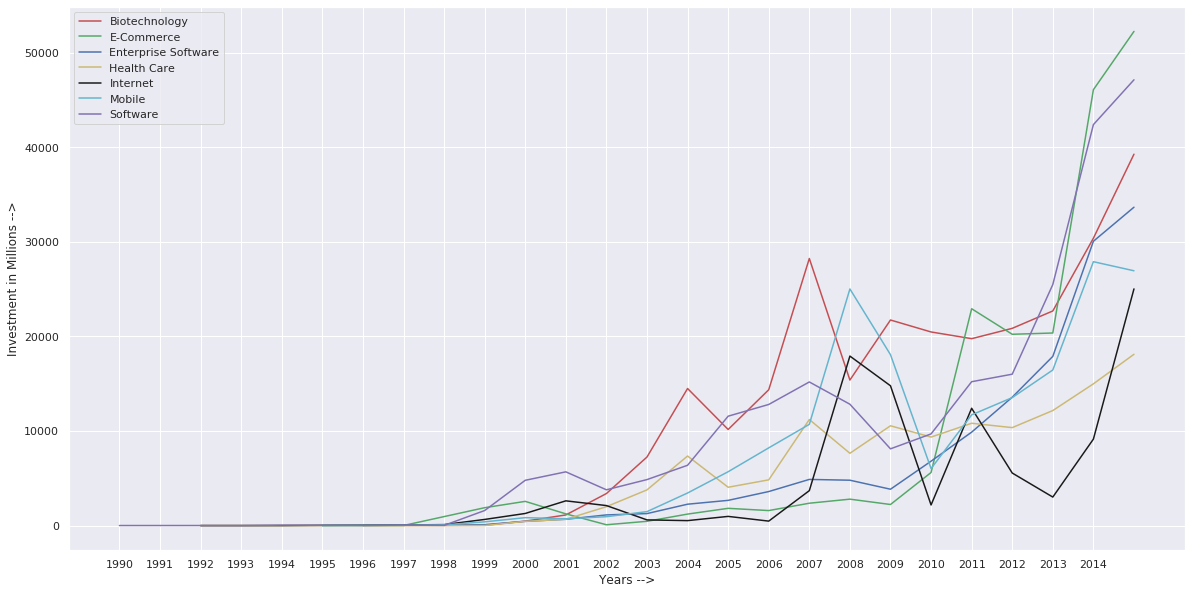

In [61]:
color=cycle('rgbykcm')
plt.figure(figsize=(20,10))

for cat,c in zip(dict,color):
    #print (cat, c)
    plt.plot(dict[cat]['Y'], dict[cat]['T'], c = c, label = cat)

plt.ylabel('Investment in Millions -->')  
plt.xlabel('Years -->')  
plt.legend()
plt.xticks(np.arange(1990, 2015, 1.0))
#plt.savefig('topCategories.png' , pi=300, quality =95 )
plt.show()